## ⚠️ IMPORTANT: Changes Made for TensorFlow 2.15.0 Compatibility

This notebook has been updated to work with **TensorFlow 2.15.0 + Keras 2.15.0** (matching ml-service requirements).

**Changes Made:**
1. **Cell 2**: Added version verification to ensure TensorFlow 2.15.0 + Keras 2.15.0 is installed
2. **Cell 2.7**: Updated model save path to ml-service directory: `E:\My Programs\smart-civic-system\ml-service\app\models\`
3. **Cell 2.7**: Now saves model in both `.keras` and `.h5` formats
4. **New Cell**: Added verification cell to test model loading

**To retrain:**
1. Ensure Python environment has TensorFlow 2.15.0 and Keras 2.15.0 installed
2. Run all cells from top to bottom
3. The model will be saved automatically to ml-service directory
4. Restart ml-service with `python -m app.main` to use the new model

**BUILDING AN IMAGE CLASSIFIER WHICH CLASSIFIES IMAGES INTO SEVERAL CIVIC CATEGORIES LIKE GARBAGE, POTHOLES, ETC.**

**IMPORTING REQUIREMENTS**

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

In [ ]:
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# Verify compatibility with ml-service
assert tf.__version__.startswith('2.15'), f"Use TensorFlow 2.15.0, you have {tf.__version__}"
assert tf.keras.__version__.startswith('2.15'), f"Use Keras 2.15.0, you have {tf.keras.__version__}"
print("✅ Environment is compatible with ml-service (TensorFlow 2.15.0 + Keras 2.15.0)")

TensorFlow version: 2.20.0
GPU available: []


**CALLING DATA FROM FILES**

In [3]:
img_size = (224, 224)
batch_size = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    "E:\\My Programs\\civic_issue_classification\\dataset\\train",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=True,
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "E:\\My Programs\\civic_issue_classification\\dataset\\val",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "E:\\My Programs\\civic_issue_classification\\dataset\\test",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=False
)


Found 24571 files belonging to 4 classes.
Found 3374 files belonging to 4 classes.
Found 2666 files belonging to 4 classes.


In [4]:
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['electricpoles', 'fallentrees', 'garbage', 'pothole']


**NORMALIZATION AND AUGMENTATION OF DATA**

In [5]:
# General augmentation for all classes
general_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# Stronger augmentation dedicated to garbage class
# garbage_augmentation = tf.keras.Sequential([
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.2),
#     layers.RandomZoom(0.2),
#     layers.RandomContrast(0.2),
# ])


In [6]:
normalization_layer = layers.Rescaling(1./255)

train_ds = (
    train_ds
    .map(lambda x, y: (general_augmentation(x, training=True), y))
    .map(lambda x, y: (normalization_layer(x), y))
    .shuffle(1000)
    # .prefetch(tf.data.AUTOTUNE)
    .prefetch(1)
)

val_ds = (
    val_ds
    .map(lambda x, y: (normalization_layer(x), y))
    # .cache()
    # .prefetch(buffer_size=tf.data.AUTOTUNE)
    .prefetch(1)
)

test_ds = (
    test_ds
    .map(lambda x, y: (normalization_layer(x), y))
    # .cache()
    # .prefetch(buffer_size=tf.data.AUTOTUNE)
    .prefetch(1)
)

**TRIED AUGMENTING(OVERSAMPLING) GARBAGE CLASS**

In [7]:
# garbage_ds = train_ds_raw.unbatch().filter(
#     lambda x, y: tf.equal(tf.argmax(y), garbage_index)
# )

# garbage_ds = garbage_ds.batch(batch_size)
# garbage_ds = garbage_ds.map(lambda x, y: (normalization_layer(x), y))
# garbage_ds = garbage_ds.map(lambda x, y: (garbage_augmentation(x, training=True), y))

# # Merge augmented garbage back
# train_ds = train_ds.concatenate(garbage_ds)


**BUILDING MODEL AND USING TRANSFER LEARNING**

**1. CUSTOM CNN**

In [8]:
# def build_civic_cnn(input_shape=(224,224,3), num_classes=4):
#     inputs = layers.Input(shape=input_shape)
#     model = models.Sequential([
#         layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
#         layers.MaxPooling2D((2,2)),

#         layers.Conv2D(64, (3,3), activation='relu'),
#         layers.MaxPooling2D((2,2)),

#         layers.Conv2D(128, (3,3), activation='relu'),
#         layers.MaxPooling2D((2,2)),

#         layers.Conv2D(256, (3,3), activation='relu'),
#         layers.MaxPooling2D((2,2)),

#         #layers.Flatten(),
#         layers.GlobalAveragePooling2D(),
#         layers.Dense(128, activation='relu'),
#         layers.Dropout(0.5),
#         layers.Dense(num_classes, activation='softmax')
#     ])
#     model.compile(optimizer='adam',
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model

# model = build_civic_cnn()
# model.summary()


**ADDING CLASS WEIGHTS AND MENTIONING CHECKPOINTS AND EARLYSTOP**


In [7]:
# RAW training dataset (ONLY for class weights)
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    "E:\\My Programs\\civic_issue_classification\\dataset\\train",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=False
)

Found 24571 files belonging to 4 classes.


In [8]:
#Adding class weights so that the balance is maintained between classes
# ===============================
# CLASS WEIGHTS
# ===============================

from sklearn.utils import class_weight
import numpy as np

labels = []

assert train_ds_raw is not None, "train_ds_raw must be defined before computing class weights"
for _, y in train_ds_raw.unbatch():
    if len(y.shape) > 0:          # one-hot
        labels.append(int(np.argmax(y.numpy())))
    else:                         # integer labels
        labels.append(int(y.numpy()))

unique_classes = np.arange(len(class_names))

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=labels
)

class_weights = dict(zip(unique_classes, class_weights))
print("Class Weights:", class_weights)

#*******************************************************************************
#Calculating steps per epoch
# train_steps = tf.data.experimental.cardinality(train_ds).numpy()
# steps_per_epoch = train_steps
# print("Steps per epoch:", steps_per_epoch)
#*******************************************************************************

# ===============================
# CALLBACKS
# ===============================
#Checkpoint for saving the best model only 
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)

#Earlystop to avoid over computation
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,            # stop if val_loss doesn’t improve for 2 epochs
    restore_best_weights=True
)

Class Weights: {np.int64(0): np.float64(0.8448287718333104), np.int64(1): np.float64(0.7226764705882353), np.int64(2): np.float64(1.9606607085860197), np.int64(3): np.float64(1.083950944062114)}


**1.1 FITTING MODEL**

In [11]:
# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=8,
#     class_weight=class_weights,
#     steps_per_epoch = steps_per_epoch,
#     callbacks=[early_stop, checkpoint]
# )

In [12]:
# model.save("civic_issue_model_customCNN.keras")

**1.2 PLOTTING THE LEARNINGS MADE**

In [13]:
# plt.plot(history.history['accuracy'], label='train acc')
# plt.plot(history.history['val_accuracy'], label='val acc')
# plt.legend()
# plt.show()

# plt.plot(history.history['loss'], label='train loss')
# plt.plot(history.history['val_loss'], label='val loss')
# plt.legend()
# plt.show()


**1.3 TESTING MODEL PERFORMANCE ON TEST_DATA**

In [14]:
# test_loss, test_acc = model.evaluate(test_ds)   #testing model performance on the test data set
# print("Test Accuracy:", test_acc)


**1.4 LET's TRY A DEMO IMAGE AND SEE HOW MODEL CLASSIFIES IT**

In [15]:
# from tensorflow.keras.preprocessing import image

# class_names = train_ds.class_names
# print("Class names:", class_names)

# img_path = "E:\\My Programs\\civic_issue_classification\\dataset\\train\\garbage\\1__aluminum-tin-cans-2_jpg.rf.3357c35942c2fcc9ec3ff705e89ed967.jpg"  # replace with any test image
# img = image.load_img(img_path, target_size=img_size)
# img_array = image.img_to_array(img)/255.0
# img_array = np.expand_dims(img_array, axis=0)

# pred = model.predict(img_array)
# print("Predicted category:", class_names[np.argmax(pred)])
# print("Prediction probabilities:", pred[0])  # show all 4 class probabilities


In [9]:
import os
for cls in class_names:
    print(cls, len(os.listdir(f"E:\\My Programs\\civic_issue_classification\\dataset\\train\\{cls}")))


electricpoles 7271
fallentrees 8500
garbage 3133
pothole 5667


**1.5 PLOTTING CONFUSION MATRIX**

In [17]:
# import seaborn as sns
# from sklearn.metrics import confusion_matrix

# y_true, y_pred = [], []
# for images, labels in test_ds:
#     preds = model.predict(images)
#     y_true.extend(np.argmax(labels.numpy(), axis=1))
#     y_pred.extend(np.argmax(preds, axis=1))

# cm = confusion_matrix(y_true, y_pred)
# sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='d')


**2. TRANSFER LEARNING MODEL**

**2.1 LOAD PRETRAINED MobileNetV2 (FEATURE EXTRACTOR)**

In [10]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

# Freeze pretrained weights
base_model.trainable = False

**2.2 BUILDING TL MODEL**

In [11]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation="softmax")
])

**2.3 COMPILING THE MODEL**

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,588 (9.26 MB)

 Trainable params: 167,044 (652.52 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

**2.4 TRAINING THE MODEL (MODEL FIT)**

In [13]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/5
1536/1536 ━━━━━━━━━━━━━━━━━━━━ 1030s 468ms/step - accuracy: 0.8605 - loss: 0.4057 - precision: 0.8731 - recall: 0.8503 - val_accuracy: 0.9244 - val_loss: 0.2111 - val_precision: 0.9324 - val_recall: 0.9164
Epoch 2/5
1536/1536 ━━━━━━━━━━━━━━━━━━━━ 1115s 474ms/step - accuracy: 0.9028 - loss: 0.2621 - precision: 0.9137 - recall: 0.8911 - val_accuracy: 0.9449 - val_loss: 0.1574 - val_precision: 0.9508 - val_recall: 0.9395
Epoch 3/5
1536/1536 ━━━━━━━━━━━━━━━━━━━━ 1121s 471ms/step - accuracy: 0.9164 - loss: 0.2309 - precision: 0.9269 - recall: 0.9079 - val_accuracy: 0.9464 - val_loss: 0.1500 - val_precision: 0.9552 - val_recall: 0.9407
Epoch 4/5
1536/1536 ━━━━━━━━━━━━━━━━━━━━ 1126s 477ms/step - accuracy: 0.9199 - loss: 0.2159 - precision: 0.9299 - recall: 0.9117 - val_accuracy: 0.9464 - val_loss: 0.1436 - val_precision: 0.9543 - val_recall: 0.9416
Epoch 5/5
1536/1536 ━━━━━━━━━━━━━━━━━━━━ 1128s 468ms/step - accuracy: 0.9249 - loss: 0.2057 - precision: 0.9340 - recall: 0.9162 - val_a

**2.5 TEST SET EVALUATION**

In [15]:
results = model.evaluate(test_ds, return_dict=True)

for k, v in results.items():
    print(f"{k}: {v:.4f}")


167/167 ━━━━━━━━━━━━━━━━━━━━ 58s 342ms/step - accuracy: 0.8856 - loss: 0.3819 - precision: 0.8937 - recall: 0.8800
accuracy: 0.8856
loss: 0.3819
precision: 0.8937
recall: 0.8800


**2.6 REPRESENTING CONFUSION MATRIX**

               precision    recall  f1-score   support

electricpoles       0.81      0.91      0.86       328
  fallentrees       0.99      0.90      0.94      1632
      garbage       0.69      0.94      0.80       337
      pothole       0.78      0.74      0.76       369

     accuracy                           0.89      2666
    macro avg       0.82      0.87      0.84      2666
 weighted avg       0.90      0.89      0.89      2666



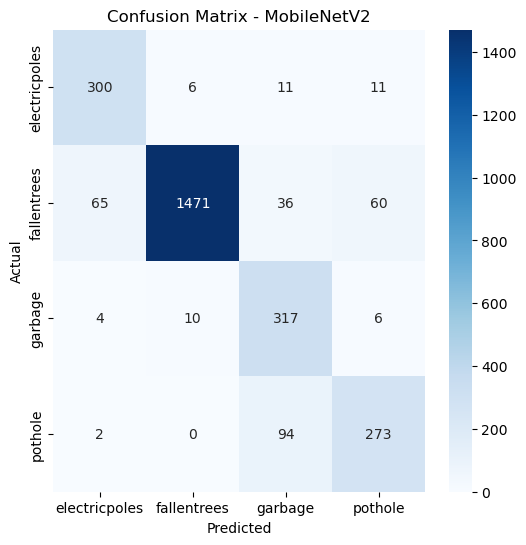

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

y_true, y_pred = [], []

for x, y in test_ds:
    preds = model.predict(x, verbose=0)
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - MobileNetV2")
plt.show()

**2.7 SAVE MODEL**

In [ ]:
# =====================================================
# SAVE BASELINE MOBILE NET MODEL TO ML-SERVICE
# =====================================================

# Save to ml-service directory
ml_service_path = r"E:\My Programs\smart-civic-system\ml-service\app\models"
os.makedirs(ml_service_path, exist_ok=True)

# Save both formats for compatibility
keras_path = os.path.join(ml_service_path, "image_classifier.keras")
h5_path = os.path.join(ml_service_path, "image_classifier.h5")

model.save(keras_path)
model.save(h5_path)

print(f"✅ Model saved to ml-service directory: {ml_service_path}")
print(f"  - {keras_path}")
print(f"  - {h5_path}")

assert os.path.exists(keras_path), "Model save failed (keras)!"
assert os.path.exists(h5_path), "Model save failed (h5)!"
print("✅ Both model formats saved successfully!")

Baseline MobileNetV2 model saved successfully!


In [ ]:
# =====================================================
# VERIFY MODEL CAN BE LOADED
# =====================================================

# Test loading the keras model
test_model = tf.keras.models.load_model(keras_path)
print("✅ Model loads successfully from keras format!")

# Test with a sample image from test set
test_images, test_labels = next(iter(test_ds))
test_pred = test_model.predict(test_images[0:1], verbose=0)
predicted_class = class_names[np.argmax(test_pred)]
print(f"✅ Prediction works! Sample predicted class: {predicted_class}")
print(f"   Confidence: {np.max(test_pred):.2%}")
print("\n✅ Model is fully compatible with TensorFlow 2.15.0 + Keras 2.15.0!")

**2.8 TRY ON A SAMPLE IMAGE**

In [18]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Load saved model
model = tf.keras.models.load_model("mobilenetv2_baseline.keras")

print("Model loaded successfully")

Model loaded successfully


In [21]:
class_names = ['electricpoles', 'fallentrees', 'garbage', 'pothole']

img_path = r"E:\My Programs\civic_issue_classification\dataset\sample_image(fallentrees).jpg"

img_size = (224, 224)

img = image.load_img(img_path, target_size=img_size)
img_array = image.img_to_array(img)
img_array = img_array / 255.0          # normalization
img_array = np.expand_dims(img_array, axis=0)  # batch dimension

predictions = model.predict(img_array)

predicted_class = class_names[np.argmax(predictions)]
confidence = np.max(predictions) * 100

print("Predicted class:", predicted_class)
print("Confidence:", f"{confidence:.2f}%")

for i, prob in enumerate(predictions[0]):
    print(f"{class_names[i]}: {prob*100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Predicted class: fallentrees
Confidence: 61.71%
electricpoles: 37.71%
fallentrees: 61.71%
garbage: 0.58%
pothole: 0.00%


**2.8 FINE-TUNE MODEL**

In [ ]:
# =====================================================
# FINE-TUNING (ADVANCED)
# =====================================================

# Unfreeze last 20 layers of MobileNetV2
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)

# Fine-tune the model
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint]
)
